In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_1 = pd.read_csv('ACT1_train_450.csv')

In [4]:
train_1.head(5)

,Unnamed: 0,D_212,D_213,D_214,D_215,D_216,D_217,D_219,D_294,D_295,...,D_7351,D_7352,D_7954,D_7955,D_7957,D_7958,D_8051,D_8053,D_8054,Act
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.0179
1,1,0,0,0,0,0,0,0,4,4,...,0,0,0,0,0,0,0,0,0,4.3003
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.2697
3,3,0,0,0,0,0,0,0,1,0,...,0,0,2,2,3,2,1,1,1,6.1797
4,4,0,0,0,0,0,0,0,0,0,...,2,0,0,2,0,1,0,0,1,4.3003


In [5]:
from sklearn.model_selection import train_test_split
import numpy as np
y = train_1['Act'].values
train_1 = train_1.drop(['Act', 'Unnamed: 0'], axis = 1)
x = train_1.values
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=0)


In [6]:
print(np.shape(Y_train), np.shape(X_train), np.shape(Y_test), np.shape(X_test))
Y_train = np.reshape(Y_train,(len(Y_train),1))
Y_test = np.reshape(Y_test,(len(Y_test),1))


(22344,) (22344, 442) (7449,) (7449, 442)


In [7]:
def r_square(X, Y):
    """ r^2 value defined by the competition host, r^2 = 1 indicates 100% prediction accuracy
    """
    avx = np.mean(X)
    avy = np.mean(Y)
    sum1, sumx, sumy = 0, 0, 0
    for i in range(len(X)):
        sum1 += (X[i] - avx)*(Y[i] - avy)
        sumx += (X[i] - avx)*(X[i] - avx)
        sumy += (Y[i] - avy)*(Y[i] - avy)
    print(len(X), sum1, sumx, sumy)
    return sum1*sum1/(sumx*sumy)

In [8]:
from keras import backend as K
#Keras R_2 function
R_2 = []
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

Using TensorFlow backend.


In [9]:
from sklearn.metrics import make_scorer
#Keras MAPE function
MAPE = []
def mean_ape(y_true, y_pred):
    return K.mean(K.abs((y_true-y_pred)/y_true))*100
#Scikit learn mape function
def mean_apes(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100
mape_func = make_scorer(mean_apes)

In [10]:
from tensorflow.keras.models import Sequential
import keras
from tensorflow.keras.layers import Dense
from keras.optimizers import Adam 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [15]:
def build_model(learn_rate):
    model = keras.models.Sequential();
    model.add(keras.layers.core.Dense(units = 40, activation='relu', input_dim = 442));
    model.add(keras.layers.core.Dense(units=20, activation = 'relu'))
    model.add(keras.layers.core.Dense(1, activation = 'relu'));
    adam = Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False);
    model.compile(optimizer=adam,loss='mean_squared_error')
    return model

In [16]:
regressor = KerasRegressor(build_fn=build_model)

In [21]:
from sklearn.model_selection import RandomizedSearchCV
parameters ={'batch_size':[50,100,200],
            'nb_epoch':[50,250,500],
            'learn_rate':[0.001,0.01]}
random_search= RandomizedSearchCV(estimator=regressor, param_distributions=parameters,n_jobs=-1,cv=5, scoring = mape_func, n_iter=18)

In [22]:
random_search.fit(x, y)

Epoch 1/1
37241/37241 [==============================] - 1s 24us/step - loss: 25.2261


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000017B7375B278>,
          fit_params=None, iid='warn', n_iter=18, n_jobs=-1,
          param_distributions={'batch_size': [50, 100, 200], 'nb_epoch': [50, 250, 500], 'learn_rate': [0.001, 0.01]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(mean_apes),
          verbose=0)

In [24]:
random_search.cv_results_['mean_test_score']

array([ 9.63080283,  9.14186533,  9.33249527,  9.34922682, 27.64333733,
       26.73386473, 10.62217689, 10.6123652 , 10.68049743, 46.46874112,
       64.34872633, 45.53963146, 12.1479899 , 12.19669162, 11.55824969,
       47.1096129 , 64.33071736, 82.01379369])

In [25]:
gridsearchdf = pd.DataFrame(random_search.cv_results_)
results = gridsearchdf[['mean_test_score','param_nb_epoch','param_learn_rate','param_batch_size']].sort_values('mean_test_score')
results

,mean_test_score,param_nb_epoch,param_learn_rate,param_batch_size
1,9.141865,250,0.001,50
2,9.332495,500,0.001,50
3,9.349227,50,0.01,50
0,9.630803,50,0.001,50
7,10.612365,250,0.001,100
6,10.622177,50,0.001,100
8,10.680497,500,0.001,100
14,11.558250,500,0.001,200
12,12.147990,50,0.001,200
13,12.196692,250,0.001,200


In [ ]:
#Manual Tuning Below

In [27]:
#Keras model
for epochs in [250]:
    for batch in [50]:
        K.clear_session()
        model = keras.models.Sequential();
        model.add(keras.layers.core.Dense(units = 40, activation='relu', input_dim = 442));
        model.add(keras.layers.core.Dense(units=20, activation = 'relu'))
        model.add(keras.layers.core.Dense(1, activation = 'relu'));
        adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False);
        model.compile(loss="mean_squared_error", optimizer=adam, metrics = [coeff_determination, mean_ape,'mae']);
        print(model.summary(), 'Epochs = ', epochs, 'Batch =', batch);
        history = model.fit(X_train, Y_train, epochs = epochs, batch_size= batch, verbose = 1);
        #print(model.evaluate(X_val, Y_val,verbose=False)[1], )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                17720     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 18,561
Trainable params: 18,561
Non-trainable params: 0
_________________________________________________________________
None Epochs =  250 Batch = 50
Epoch 1/250
22344/22344 [==============================] - 1s 33us/step - loss: 0.9766 - coeff_determination: -1.5481 - mean_ape: 14.5499 - mean_absolute_error: 0.6893
Epoch 2/250
22344/22344 [==============================] - 1s 24us/step - loss: 0.3346 - coeff_determination: 0.0788 - mean_ape: 9.1643 - mean_absolute_error: 0.4393
Epoch 3/250
22344/22344 [=============

22344/22344 [==============================] - 1s 24us/step - loss: 0.1124 - coeff_determination: 0.6998 - mean_ape: 4.9463 - mean_absolute_error: 0.2397
Epoch 46/250
22344/22344 [==============================] - 1s 24us/step - loss: 0.1100 - coeff_determination: 0.6963 - mean_ape: 4.9192 - mean_absolute_error: 0.2381
Epoch 47/250
22344/22344 [==============================] - 1s 23us/step - loss: 0.1128 - coeff_determination: 0.6937 - mean_ape: 4.9828 - mean_absolute_error: 0.2411
Epoch 48/250
22344/22344 [==============================] - 1s 24us/step - loss: 0.1086 - coeff_determination: 0.7057 - mean_ape: 4.8935 - mean_absolute_error: 0.2368
Epoch 49/250
22344/22344 [==============================] - 1s 23us/step - loss: 0.1073 - coeff_determination: 0.7045 - mean_ape: 4.8547 - mean_absolute_error: 0.2349
Epoch 50/250
22344/22344 [==============================] - 1s 24us/step - loss: 0.1101 - coeff_determination: 0.6991 - mean_ape: 4.9173 - mean_absolute_error: 0.2380
Epoch 51/25

22344/22344 [==============================] - 1s 29us/step - loss: 0.0771 - coeff_determination: 0.7892 - mean_ape: 4.1151 - mean_absolute_error: 0.1984
Epoch 95/250
22344/22344 [==============================] - 1s 27us/step - loss: 0.0748 - coeff_determination: 0.7977 - mean_ape: 4.0395 - mean_absolute_error: 0.1948
Epoch 96/250
22344/22344 [==============================] - 1s 26us/step - loss: 0.0768 - coeff_determination: 0.7867 - mean_ape: 4.1307 - mean_absolute_error: 0.1990
Epoch 97/250
22344/22344 [==============================] - ETA: 0s - loss: 0.0777 - coeff_determination: 0.7822 - mean_ape: 4.1355 - mean_absolute_error: 0.19 - 1s 26us/step - loss: 0.0778 - coeff_determination: 0.7827 - mean_ape: 4.1339 - mean_absolute_error: 0.1994
Epoch 98/250
22344/22344 [==============================] - 1s 25us/step - loss: 0.0794 - coeff_determination: 0.7818 - mean_ape: 4.1885 - mean_absolute_error: 0.2019
Epoch 99/250
22344/22344 [==============================] - 1s 26us/step - l

22344/22344 [==============================] - 1s 31us/step - loss: 0.0639 - coeff_determination: 0.8240 - mean_ape: 3.7702 - mean_absolute_error: 0.1814
Epoch 143/250
22344/22344 [==============================] - 1s 31us/step - loss: 0.0622 - coeff_determination: 0.8270 - mean_ape: 3.7203 - mean_absolute_error: 0.1789
Epoch 144/250
22344/22344 [==============================] - 1s 32us/step - loss: 0.0620 - coeff_determination: 0.8290 - mean_ape: 3.7061 - mean_absolute_error: 0.1782
Epoch 145/250
22344/22344 [==============================] - 1s 30us/step - loss: 0.0618 - coeff_determination: 0.8292 - mean_ape: 3.7038 - mean_absolute_error: 0.1780
Epoch 146/250
22344/22344 [==============================] - 1s 23us/step - loss: 0.0627 - coeff_determination: 0.8288 - mean_ape: 3.7298 - mean_absolute_error: 0.1792
Epoch 147/250
22344/22344 [==============================] - 1s 26us/step - loss: 0.0623 - coeff_determination: 0.8283 - mean_ape: 3.7115 - mean_absolute_error: 0.1786
Epoch 

22344/22344 [==============================] - 1s 23us/step - loss: 0.0560 - coeff_determination: 0.8496 - mean_ape: 3.5365 - mean_absolute_error: 0.1697
Epoch 191/250
22344/22344 [==============================] - 1s 25us/step - loss: 0.0538 - coeff_determination: 0.8514 - mean_ape: 3.4442 - mean_absolute_error: 0.1656
Epoch 192/250
22344/22344 [==============================] - 1s 24us/step - loss: 0.0529 - coeff_determination: 0.8542 - mean_ape: 3.4308 - mean_absolute_error: 0.1647
Epoch 193/250
22344/22344 [==============================] - 1s 23us/step - loss: 0.0540 - coeff_determination: 0.8517 - mean_ape: 3.4418 - mean_absolute_error: 0.1653
Epoch 194/250
22344/22344 [==============================] - 1s 23us/step - loss: 0.0546 - coeff_determination: 0.8483 - mean_ape: 3.4800 - mean_absolute_error: 0.1671
Epoch 195/250
22344/22344 [==============================] - 1s 23us/step - loss: 0.0521 - coeff_determination: 0.8528 - mean_ape: 3.4017 - mean_absolute_error: 0.1633
Epoch 

22344/22344 [==============================] - 1s 32us/step - loss: 0.0471 - coeff_determination: 0.8695 - mean_ape: 3.2295 - mean_absolute_error: 0.1549
Epoch 239/250
22344/22344 [==============================] - 1s 32us/step - loss: 0.0468 - coeff_determination: 0.8706 - mean_ape: 3.2224 - mean_absolute_error: 0.1544
Epoch 240/250
22344/22344 [==============================] - 1s 33us/step - loss: 0.0471 - coeff_determination: 0.8704 - mean_ape: 3.2419 - mean_absolute_error: 0.1554
Epoch 241/250
22344/22344 [==============================] - 1s 25us/step - loss: 0.0483 - coeff_determination: 0.8665 - mean_ape: 3.2976 - mean_absolute_error: 0.1580
Epoch 242/250
22344/22344 [==============================] - 1s 24us/step - loss: 0.0479 - coeff_determination: 0.8684 - mean_ape: 3.2564 - mean_absolute_error: 0.1562
Epoch 243/250
22344/22344 [==============================] - 1s 25us/step - loss: 0.0470 - coeff_determination: 0.8680 - mean_ape: 3.2108 - mean_absolute_error: 0.1540
Epoch 

In [28]:
print(history.history.keys())

dict_keys(['loss', 'coeff_determination', 'mean_ape', 'mean_absolute_error'])


In [29]:
print(model.evaluate(X_val, Y_val,verbose=False))
print(model.evaluate(X_test, Y_test,verbose=False))

[0.20318437818233745, 0.41867823682717425, 5.997853089608132, 0.29616677120856133]
[0.20132217200062613, 0.42855198553927487, 6.024937081295366, 0.2970170597611442]


In [30]:
Y_predict = model.predict(X_test)
np.mean(np.abs((Y_predict-Y_test)/Y_test))*100

6.024937249574961

In [31]:
np.mean(np.abs((Y_predict-Y_test)))

0.2970170631004638

In [32]:
mean_apes(Y_predict,Y_test)

6.269219708924085

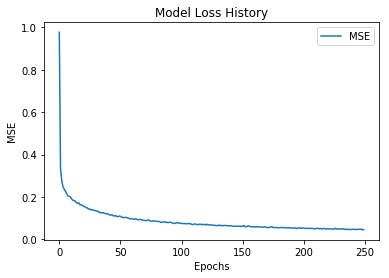

In [33]:
plt.plot(history.history['loss'])
#plt.plot(history.history['mean_ape'])
plt.title('Model Loss History')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['MSE'])


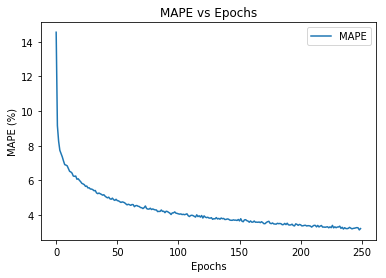

In [34]:
plt.plot(history.history['mean_ape'])
#plt.plot(history.history['mean_ape'])
plt.title('MAPE vs Epochs')
plt.ylabel('MAPE (%)')
plt.xlabel('Epochs')
plt.legend(['MAPE'])


8.665667607431685


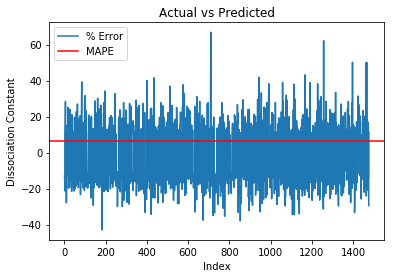

In [39]:
comparison = np.ravel((Y_predict-Y_test)/Y_test*100)
abs_comparison = np.abs(comparison)
mask = np.where(abs_comparison>10)
plt.plot(range(np.shape(mask)[1]), comparison[mask])
plt.axhline(y=mean_apes(Y_predict,Y_test), color='r', linestyle='-')
plt.title('Actual vs Predicted')
plt.ylabel('Dissociation Constant')
plt.xlabel('Index')
plt.legend(['% Error', 'MAPE'])
print(comparison.std())

In [36]:
import seaborn as sns
hyp = pd.DataFrame()

In [37]:
hyp['MAPE'] = random_search.cv_results_['mean_test_score']
hyp['index'] = hyp.index + 1
hyp

,MAPE,index
0,9.630803,1
1,9.141865,2
2,9.332495,3
3,9.349227,4
4,27.643337,5
5,26.733865,6
6,10.622177,7
7,10.612365,8
8,10.680497,9
9,46.468741,10


C:\Users\willi\Anaconda3\envs\data-x\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\willi\Anaconda3\envs\data-x\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


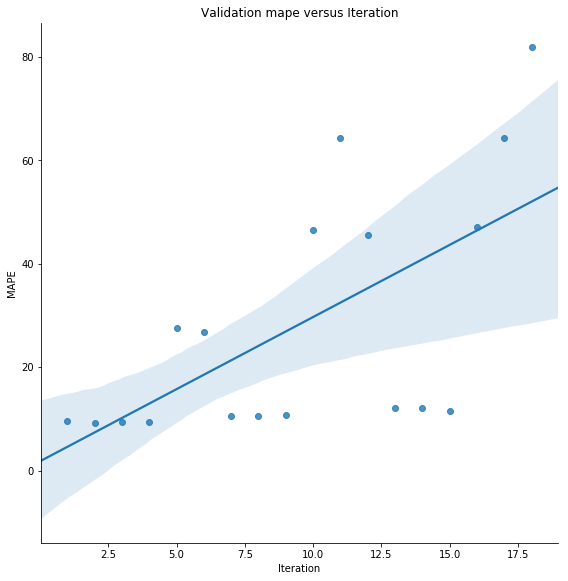

In [38]:
# MAPE Score
#hyp.sort_values('mean_test_score', inplace = True)

# Plot of scores over the course of searching
#sns.lmplot(hyp.index.values, hyp['MAPE'], data = hyp, hue = 'data', size = 8);
sns.lmplot('index', 'MAPE',data=hyp, size = 8);
#plt.scatter(hyp.index, hyp['MAPE'],  marker = '*', s = 400, c = 'blue')

plt.xlabel('Iteration'); plt.ylabel('MAPE'); plt.title("Validation mape versus Iteration");